# Initial Comments

This notebook focuses on binary semantic segmentation of on the CamVid dataset using the ResNext encoder backbone. We have tried 5 different encoders and documented the results in the code below.

Heavy reference has been taken from the [**Segmentation Models PyTorch**](https://github.com/albu/albumentations/) GitHub repo by [**Qubvel**](https://github.com/qubvel) and the example code provided.

I was initially planning on implementing UNet architecture from scratch on the [**Indian Driving Dataset**](https://idd.insaan.iiit.ac.in/). However, despite having a fairly good understanding of how it works, I was getting stuck at every single point - right from importing the dataset in a functional way to hundreds of datatype/shape mismatches. So, given the time constraint, it became apparent that I would need helper code and libraries. 

So I admit that a lot of the code till the model training is not original, however I did try my best to understand everything

Have commented explanations and inferences at a lot of places through comments and/or markdown.
Do go through the post-commments as well!

(P.S. Training takes WAY TOO LONG to run, took me 3.5 hours to run everything. You can run the training again since I have best model parameters from my testing saved (will be imported from GDrive), but note that the inference comments may seem a bit irrelevant then depending on output)

In [ ]:
""" DON'T CLICK RUN ALL (I mean you can but well) Just go through the code block by block"""


# Road Segmentation Code

## Loading data

We are using the **CamVid** dataset (by Cambridge University). It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images are (320x480); all seg-masks are binary and one-hot encoded.

http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

Here, we use a simplified version of the CamVid dataset from the GitHub repo mentioned earlier in the Initial Comments

In [ ]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user 

!pip install gdown


In [ ]:
"""I had saved the best saved models from my training run which took 3-4 hrs. 
Each .pth file was 100 mb+. Couldn't upload it on GitHub directly, so I'm importing it from my GDrive"""
import gdown
import zipfile
import os

# Define the file ID from Google Drive
file_id = '1pG-3kJsfQqUG4doOHMb8QreKJL3EjXQy'

# Define the destination file path
destination_path = 'downloaded_file.zip'

# Download the file from Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination_path, quiet=False)

# Extract the zip file
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall('.')

# Remove the zip file
os.remove(destination_path)



In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Turned off SSL verification due to errors
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [4]:
DATA_DIR = './data/CamVid/'

# load repo with data if it doesn't exist in the directory
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')


In [5]:
# Final paths of images / seg-masks
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')


In [6]:
# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


### Dataloader

Helper class for data extraction, tranformation and preprocessing  

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


In [8]:
# Class that builds on the original Dataset class provided by torch.utils.data by inheriting from it

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)


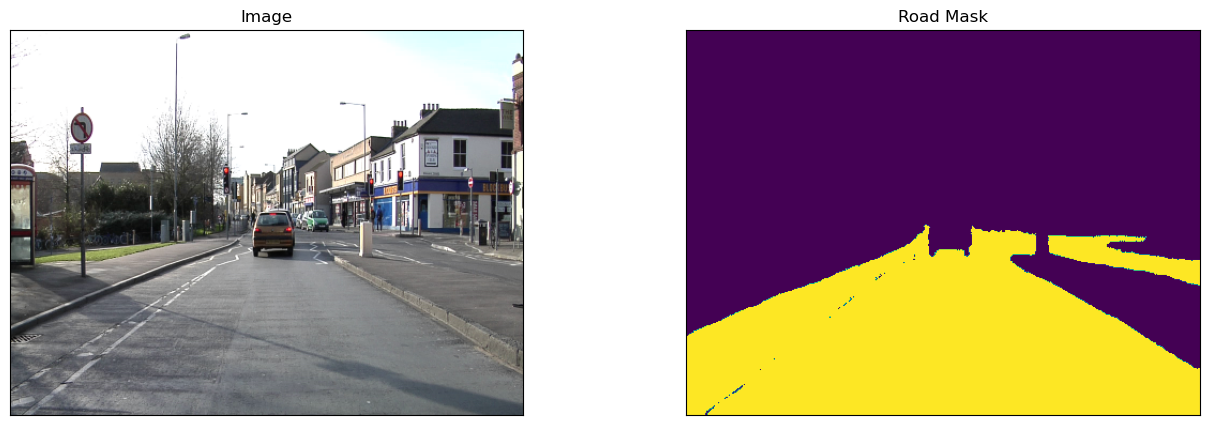

In [9]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['road'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    road_mask=mask.squeeze(),
)


### Data Augmentations

Obtaining data for Computer Vision can be expensive, hence we try to augment our data so that we can artificially 'create' more data from existing images so that diverse conditions can be simulated

Our dataset is relatively very small, so we will apply a large number of different pixel-level and spatial-level augmentations:
 - horizontal flip
 - affine transforms
 - random crops
 - gaussian noise
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 


Augmentation library used : [**Albumentations**](https://github.com/albu/albumentations/)


The library has many other interesting augmentations like add_fog, add_gravel, add_rain, add_snow, add_shadow and add_sun_flare - augmentations relevant to the deployment conditions can be used to improve our dataset.
However, due to computational constraints, we choose to apply basic transformations only

In [10]:
import albumentations as albu


In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1), # Contrast Limited Adaptive Histogram Equalization
                albu.RandomGamma(p=1), # Random gamma correction to simulate different lighting conditions
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1), # Changes HSV values by +-20 or +-30
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


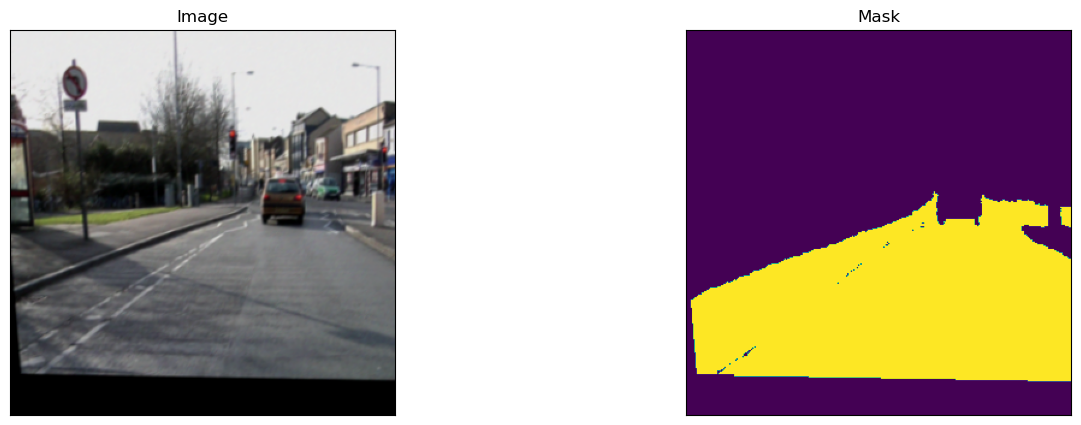

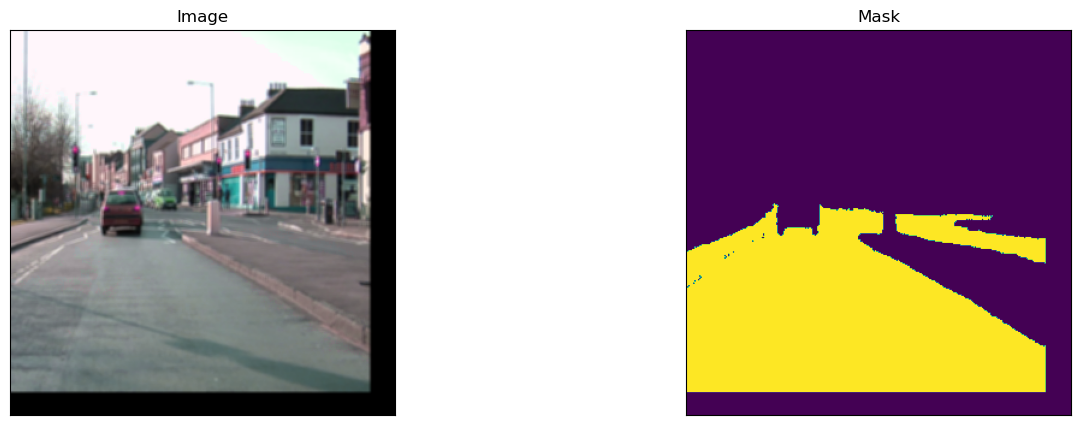

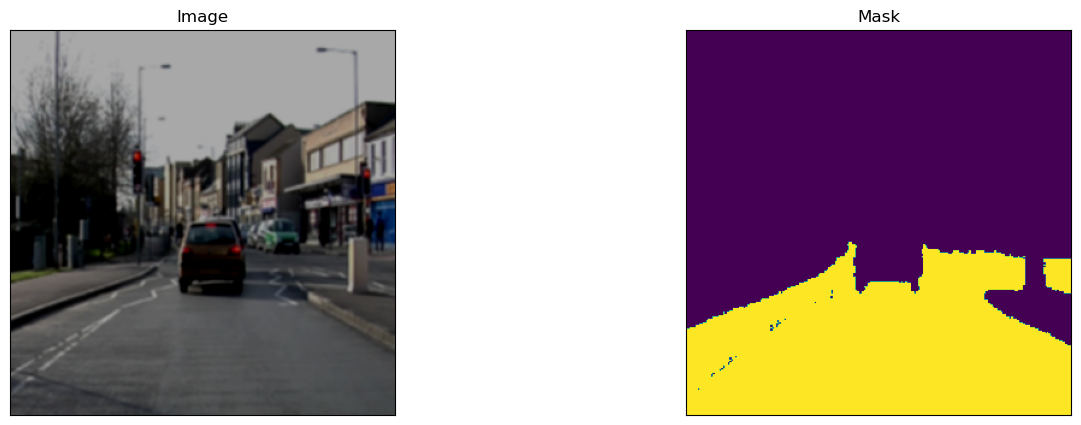

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['road'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[5]
    visualize(image=image, mask=mask.squeeze(-1))


## Create model and train

We use encoders pre-trained on ImageNet, so that we only need to train the decoder part of the architecture.

Models used are the 5 commonly used image segmentation models provided by the segmentation_models_pytorch library :

- UNet - Fully convolutional neural network with U-shaped architecture
- UNet++ - UNet modified with more dense/complex skip connections between encoder and decoder blocks
- LinkNet
- FPN (Feature Pyramid Network)
- PSPNet (Pyramid Scene Parsing Network)

To keep things consistent, ResNext50 encoder trained on ImageNet is used for all models

Since the task at hand is binary classification, we use a Sigmoid activation layer at the end

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics


In [14]:

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid' # could be None for logits or 'sigmoid' for singlec class or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation models with pretrained encoder
models = []
model_types = [smp.Unet, smp.UnetPlusPlus, smp.Linknet, smp.FPN, smp.PSPNet]

for model_type in model_types:
    model = model_type(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=len(CLASSES), activation=ACTIVATION)
    models.append(model)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


- Loss function used is Dice Loss 
- Accuracy metric used is IoU (Intersection over Union), which measures the overlap between the mask predicted and the ground-truth mask for each class. It penalizes cases where either precision or recall is low


In [15]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)


In [17]:
# Initially used bigger batch_size, but modified due to unexpected memory leaks
# Smaller batch_size increases variance of the gradient estimator, which may have caused a slight improvement in accuracy
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [1]:
""" DON'T RUN THIS IF YOU DON'T HAVE AT LEAST 3 HRS TO SPARE """
""" Would suggest to just skip running everything till the Testing part (using model parameters that I got when I ran the training). 
    But DEFINITELY do read through it, since I have noted my observations and stuff"""

# Tracks lists of IoU scores for every epoch of every model
iou_score = []
dice_loss = []

#
epochs = 40

for model in models:

    torch.cuda.empty_cache()

    model_scores = []
    model_losses = []

    optimizer = torch.optim.Adam([ 
        dict(params=model.parameters(), lr=0.0001),
    ])

    # create epoch runners 
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    max_score = 0
    
    print("-"*10, model.name, "-"*10)
    for i in range(epochs):
        
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        
        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model_'+model.name+'.pth')
            print('Model saved!')

        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')

        model_scores.append((valid_logs['iou_score']).item())
        model_losses.append(train_logs['dice_loss'].item()) 
    
    iou_score.append(model_scores)
    dice_loss.append(model_losses)
    torch.cuda.empty_cache()

    print("-x"*10)
     
    # Ignore; may be used to check memory leaks
    """ del loss,train_epoch,valid_epoch,train_logs,valid_logs,model_scores,train_loader,valid_loader,train_dataset,valid_dataset,preprocessing_fn,metrics,optimizer,model

    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size())
        except:
            pass """
    
    



NameError: name 'models' is not defined

## Plotting Training Loss

In [ ]:
# Just to see plausibility
print(iou_score[:][:5])


[[0.8902533449748956, 0.926204759295624, 0.934308649879871, 0.9518343216121786, 0.9247935325792523, 0.9329781455568747, 0.9475002129479212, 0.9558133748498292, 0.9487831651574317, 0.9172844455973939, 0.951059616438233, 0.9636574039364806, 0.9630020384741299, 0.9586190575420268, 0.9523077447815699, 0.8328492517518526, 0.9623806470691567, 0.8918476913234973, 0.9642600700406746, 0.9678214623196292, 0.9635709724803961, 0.9561682066114822, 0.9637835952314999, 0.9619432298263704, 0.8300644477995315, 0.9474358298990988, 0.9476356087344706, 0.9506589032635829, 0.9529059440782752, 0.9537890010541025, 0.9567180004450354, 0.9596711420776823, 0.966810631870043, 0.9622905484520564, 0.9645397881470105, 0.9660505534398671, 0.9648347715340035, 0.9685353943617037, 0.9690273445431546, 0.9707531273955166], [0.90169494163872, 0.8614467736518028, 0.9612543653733661, 0.95475179606145, 0.9705458672920079, 0.9628936093632539, 0.9633493653618465, 0.9628484733033887, 0.9507834799218886, 0.9662285399909065, 0.94

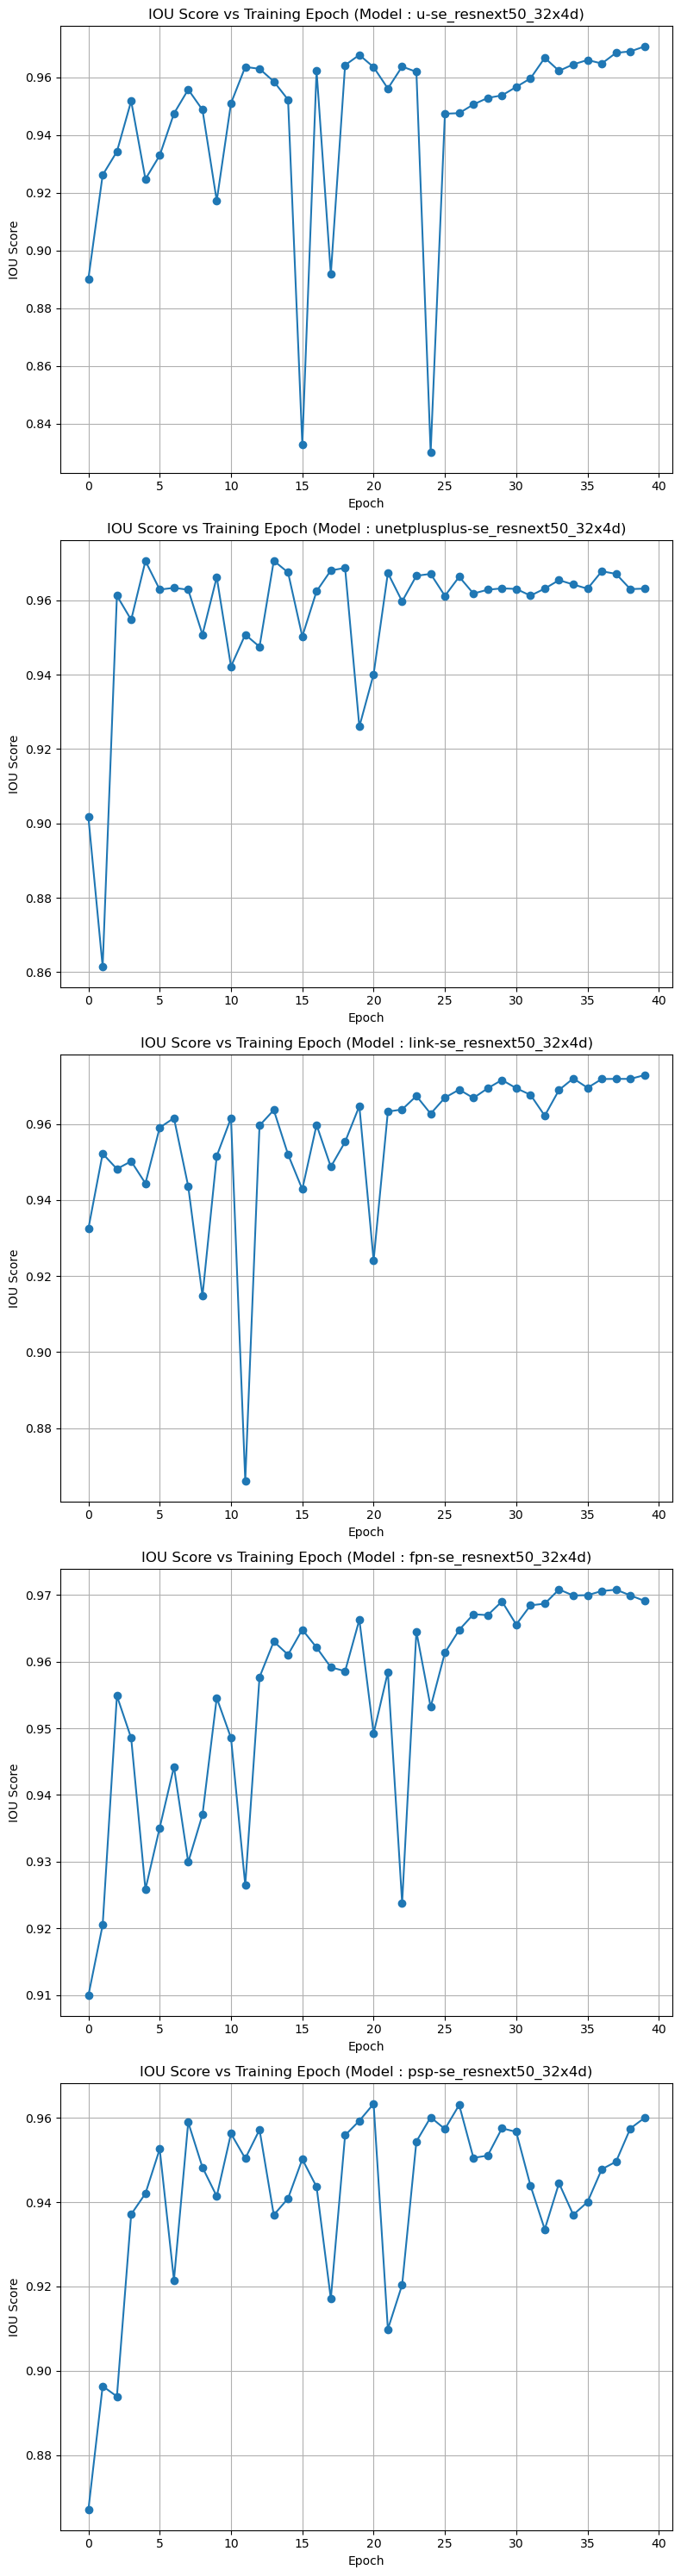

In [29]:
# Number of iou_lists
num_models = len(models)

# Create subplots
fig, axs = plt.subplots(num_models, 1, figsize=(8, 6*num_models))

# Plot each iou_list
for i, iou_list in enumerate(iou_score):
    axs[i].plot(range(len(iou_list)), iou_list, marker='o')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('IOU Score')
    axs[i].set_title(f'IOU Score vs Training Epoch (Model : {models[i].name})')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


We observe that UNet++ significantly improves over UNet in terms of convergence; stable convergence is reached earlier due to denser skip connections. This is in accordance with the UNet++ paper, a section of which we have attached here. However, surprisingly, the IoU score is just slightly less than basic UNet

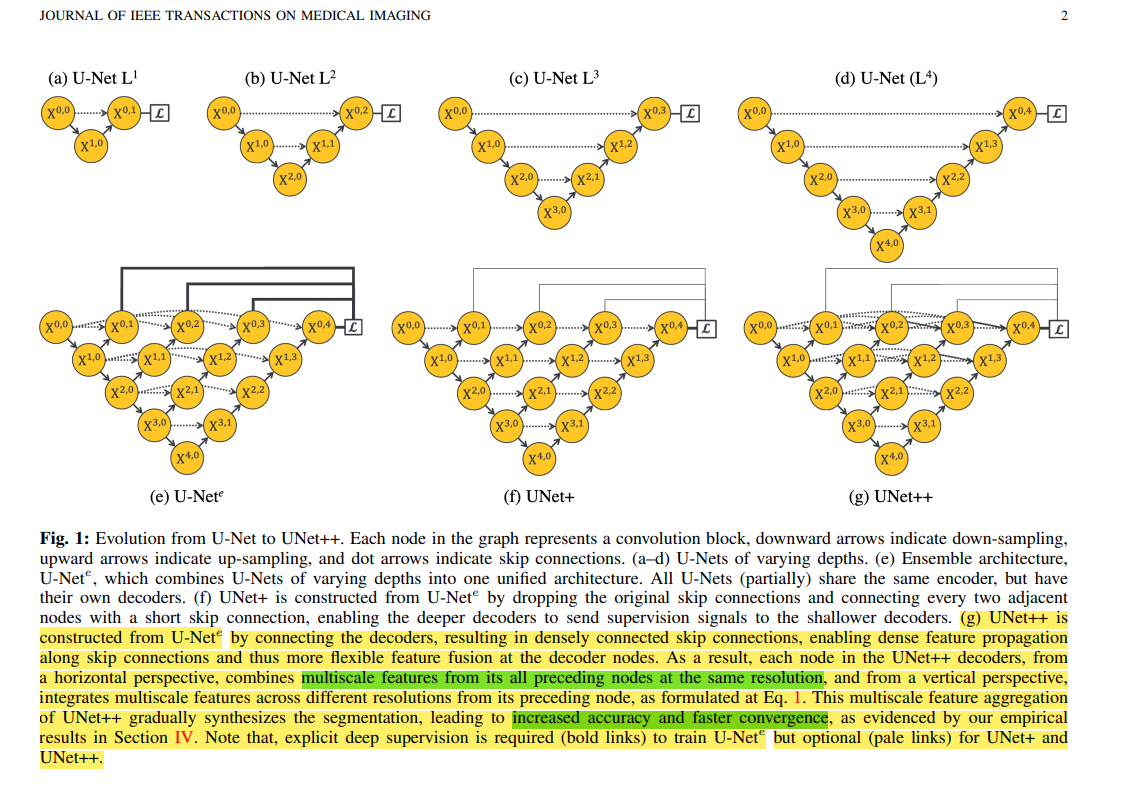

NameError: name 'dice_loss' is not defined

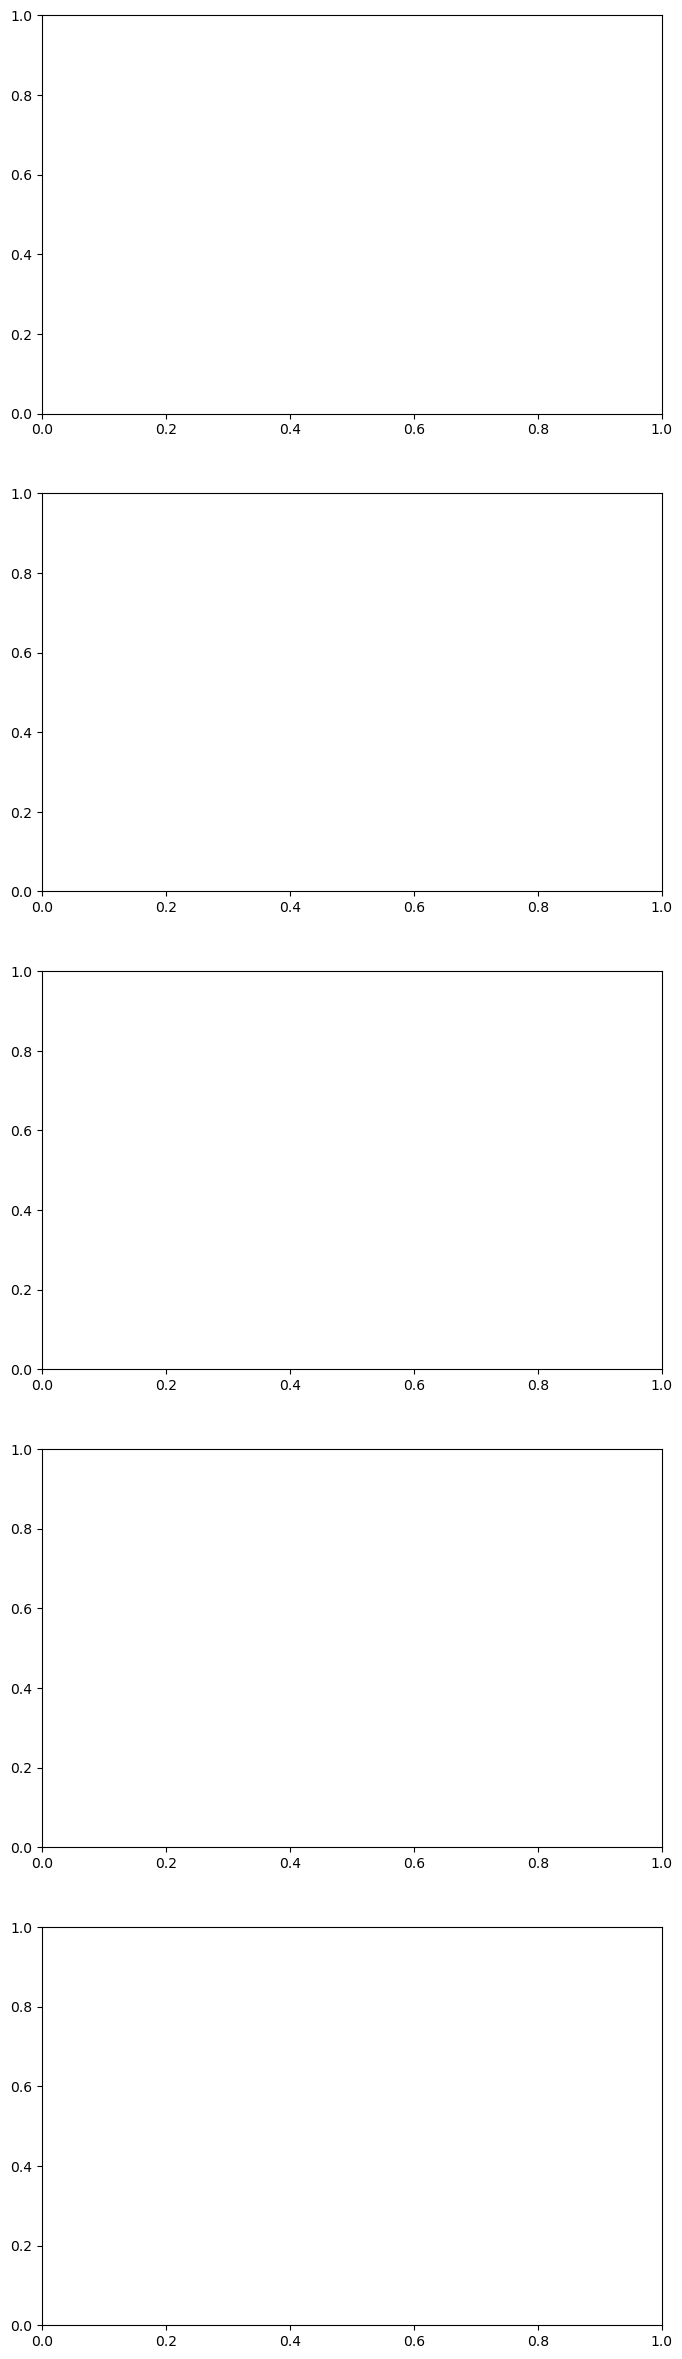

In [30]:
"""############################################## Forgot to add this initially; couldn't run training again due to time constraint (entire training loop took 3.5 hrs :P) ######################################################"""
""" # Create subplots
fig, axs = plt.subplots(num_models, 1, figsize=(8, 6*num_models))

# Plot each iou_list
for i, dice_list in enumerate(dice_loss):
    axs[i].plot(range(len(dice_list)), dice_list, marker='o')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Dice Loss')
    axs[i].set_title(f'Dice Loss vs Training Epoch : (Model : {model.name})')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
 """


## Testing Best Saved Models and Visualizing

In [25]:
# create test dataset
test_dataset = Dataset(
        x_test_dir, 
        y_test_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES
    )

# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)


-----u-se_resnext50_32x4d-----
valid: 100%|██████████| 233/233 [00:13<00:00, 17.46it/s, dice_loss - 0.06032, iou_score - 0.8903]


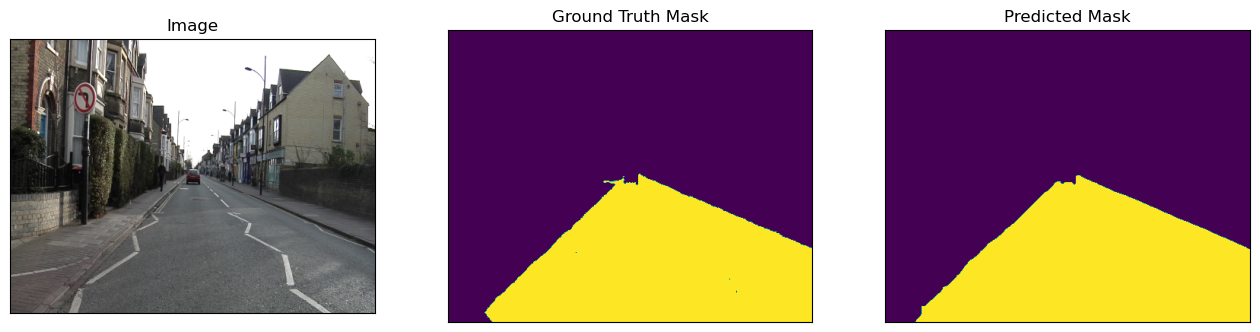

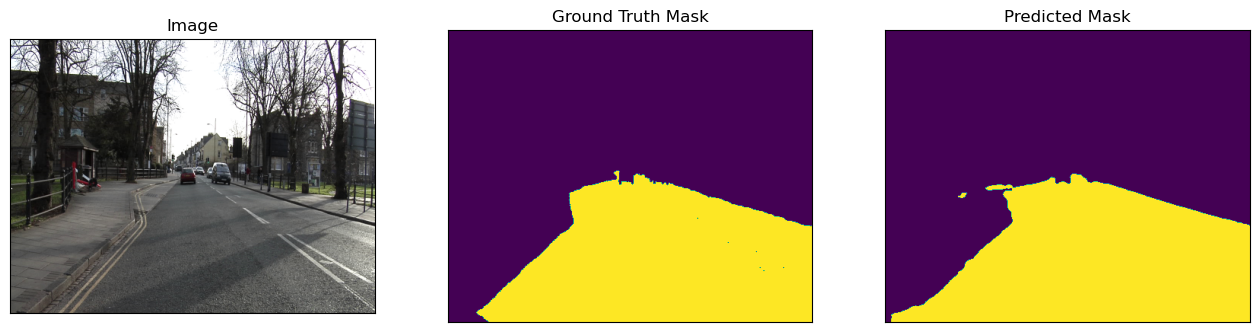

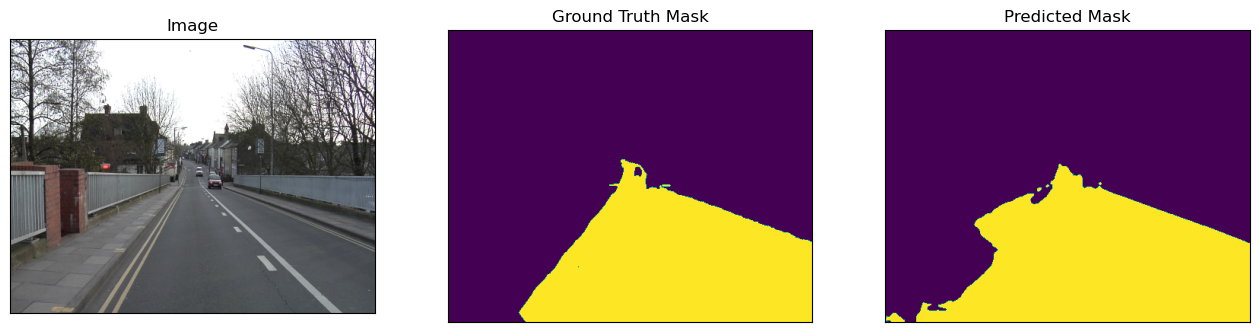

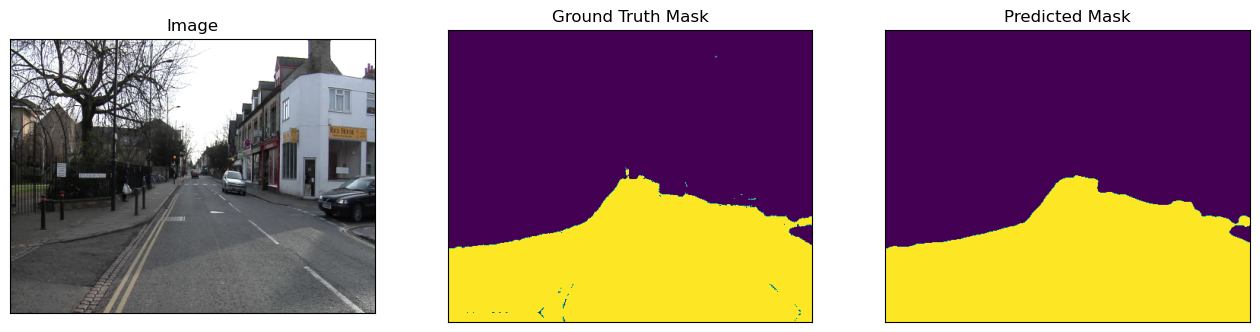

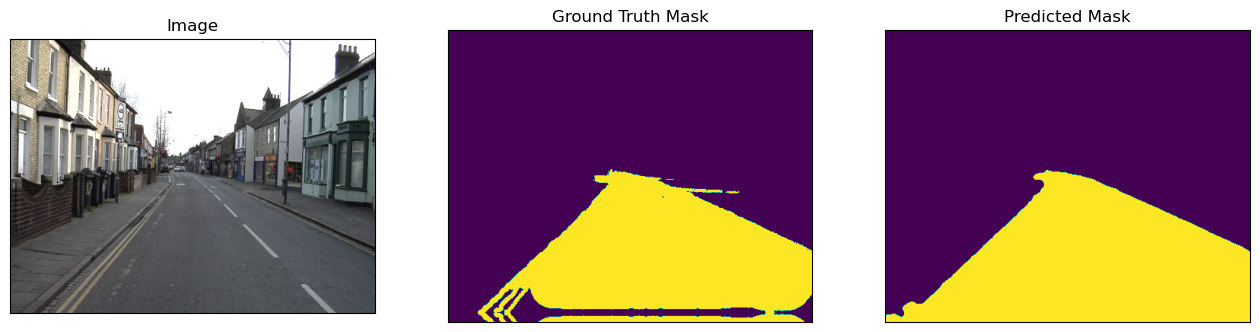

-X-X-X-X-X-X-X-X-X-X


-----unetplusplus-se_resnext50_32x4d-----
valid: 100%|██████████| 233/233 [00:32<00:00,  7.20it/s, dice_loss - 0.0621, iou_score - 0.8874] 


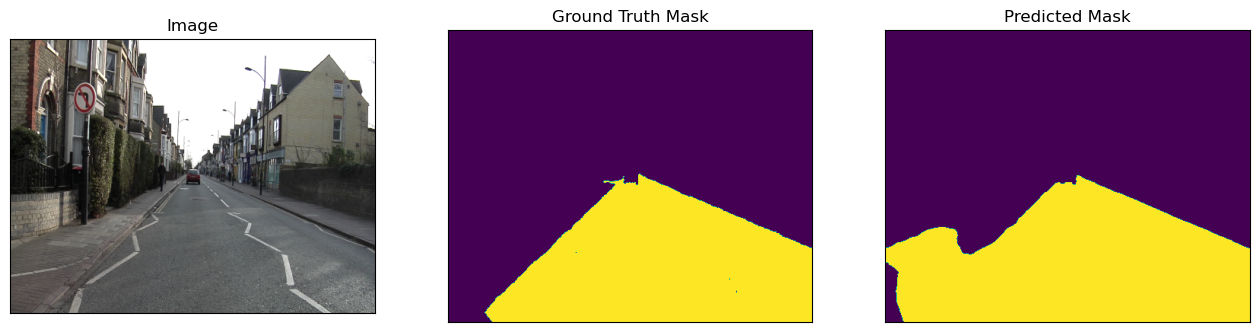

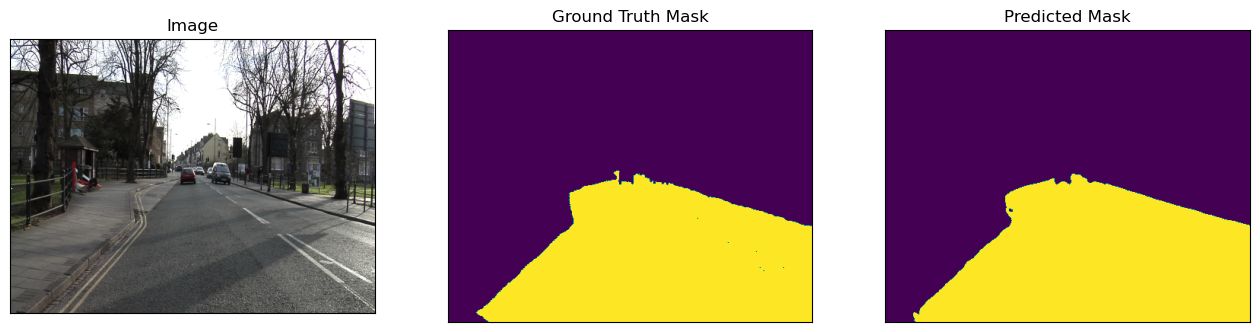

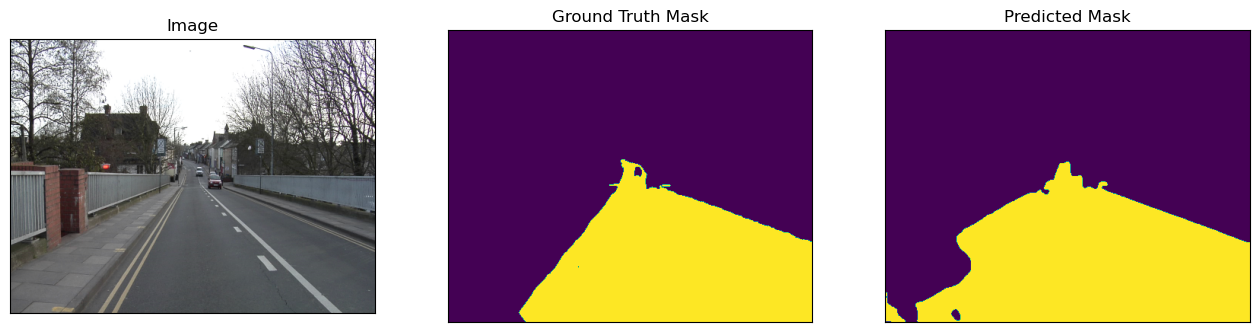

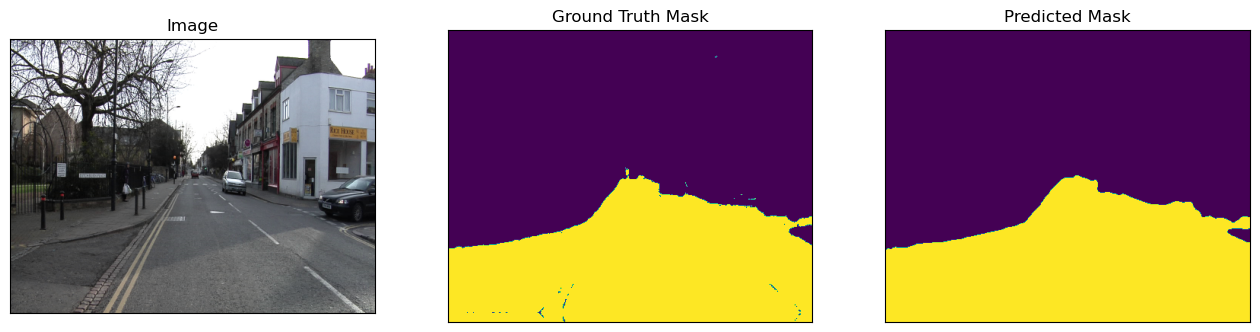

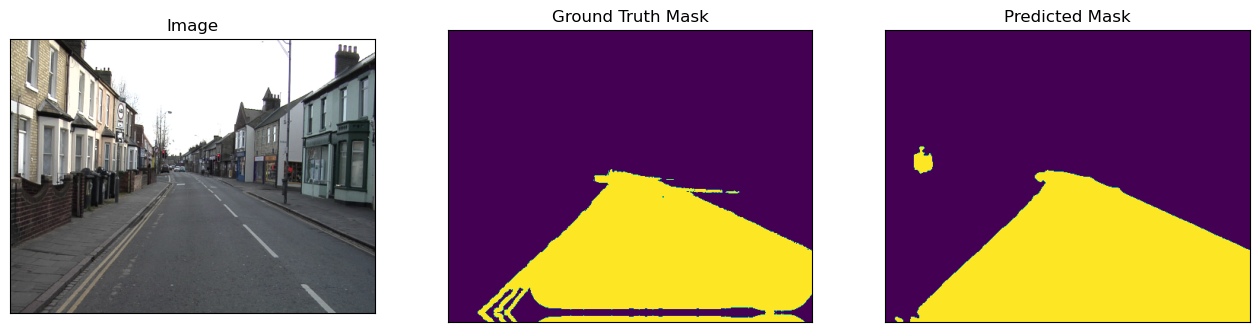

-X-X-X-X-X-X-X-X-X-X


-----link-se_resnext50_32x4d-----
valid: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s, dice_loss - 0.04074, iou_score - 0.9239]


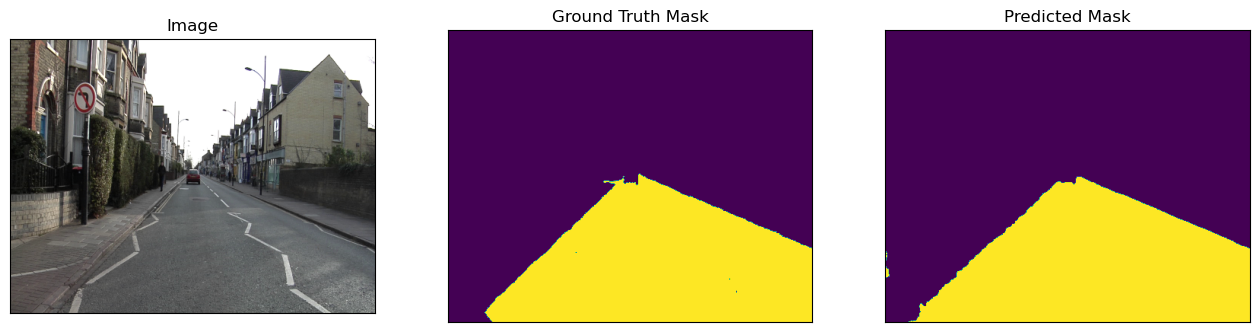

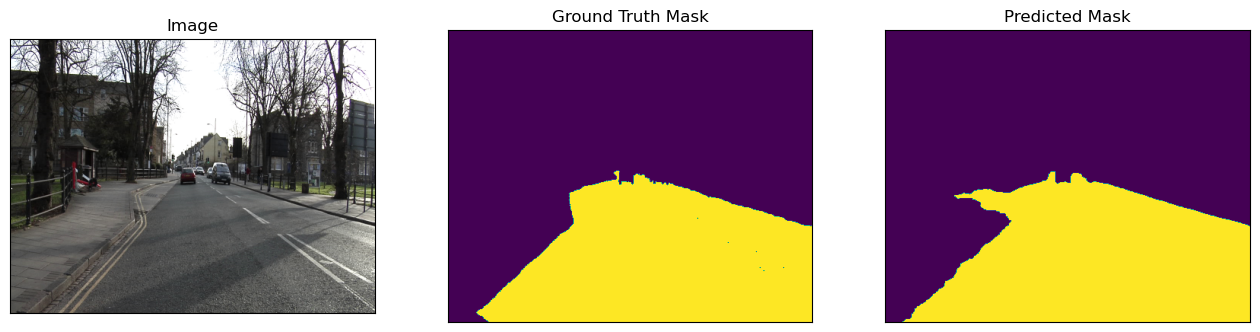

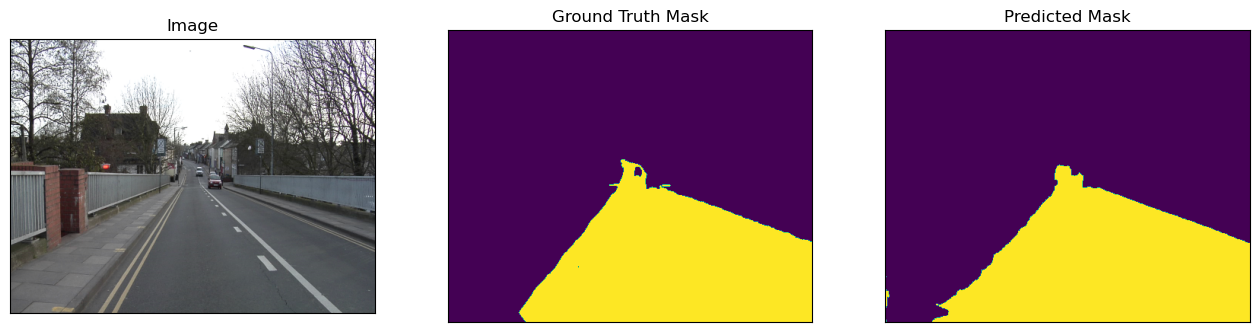

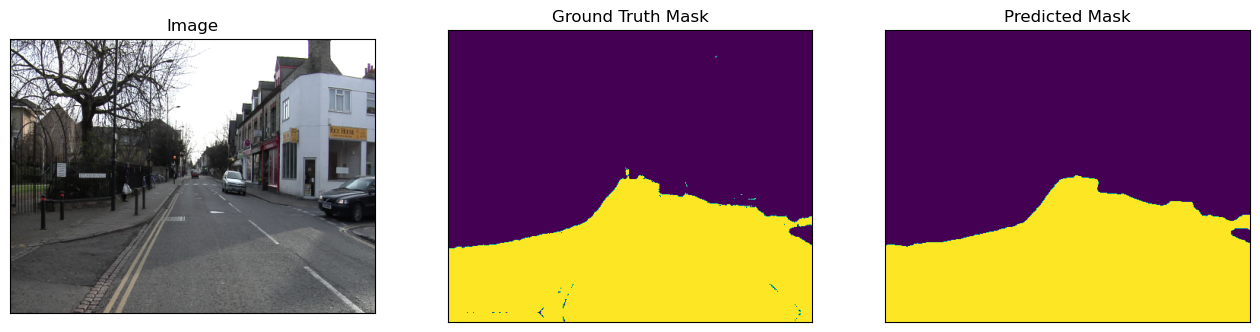

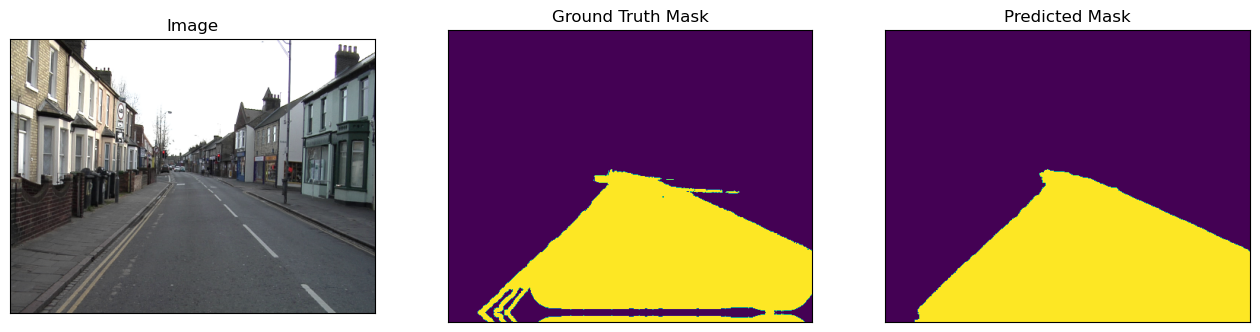

-X-X-X-X-X-X-X-X-X-X


-----fpn-se_resnext50_32x4d-----
valid: 100%|██████████| 233/233 [00:11<00:00, 19.45it/s, dice_loss - 0.04626, iou_score - 0.9169]


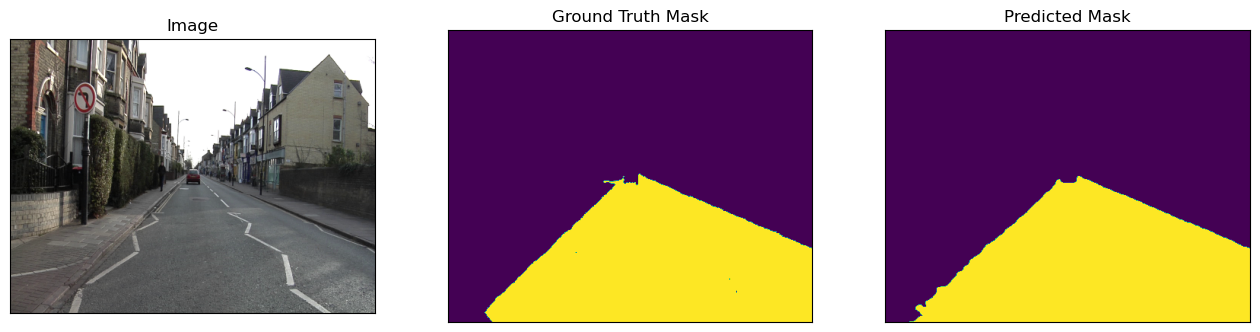

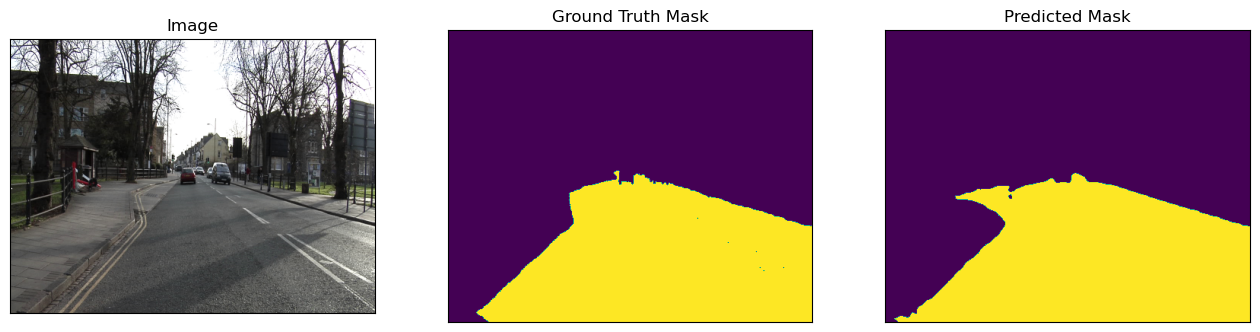

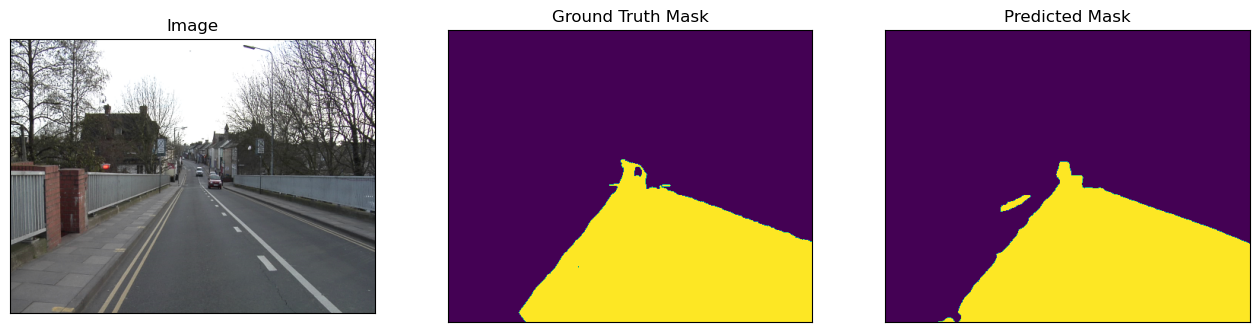

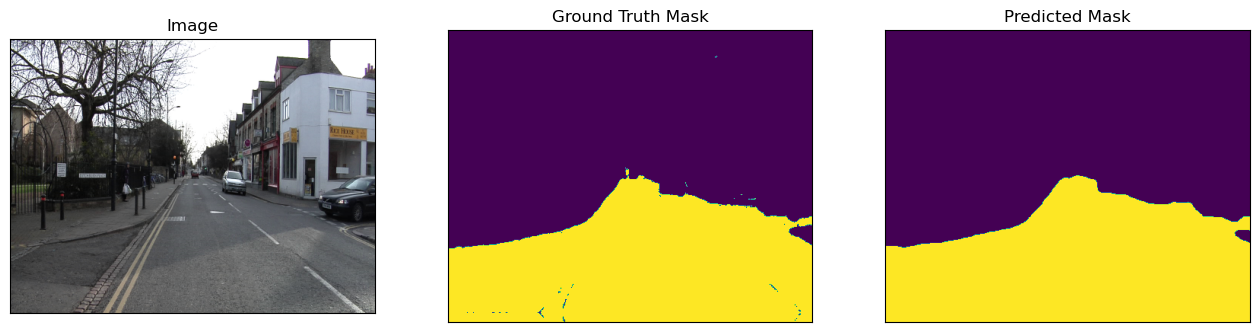

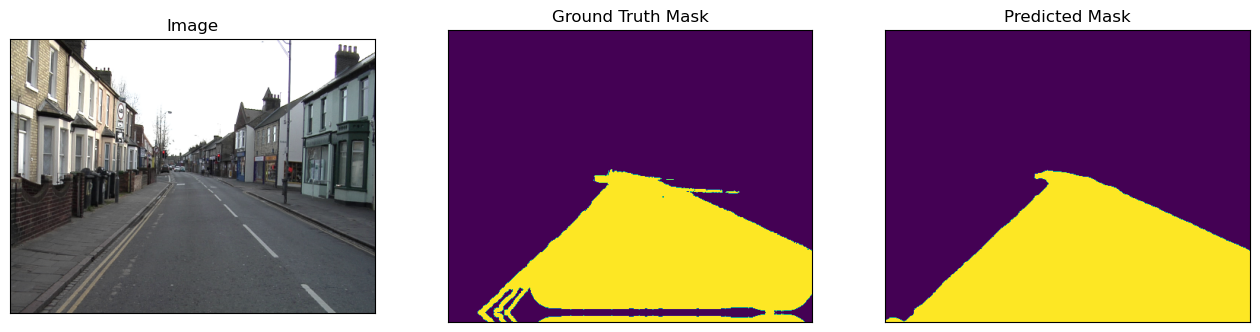

-X-X-X-X-X-X-X-X-X-X


-----psp-se_resnext50_32x4d-----
valid: 100%|██████████| 233/233 [00:08<00:00, 28.67it/s, dice_loss - 0.08903, iou_score - 0.8571]


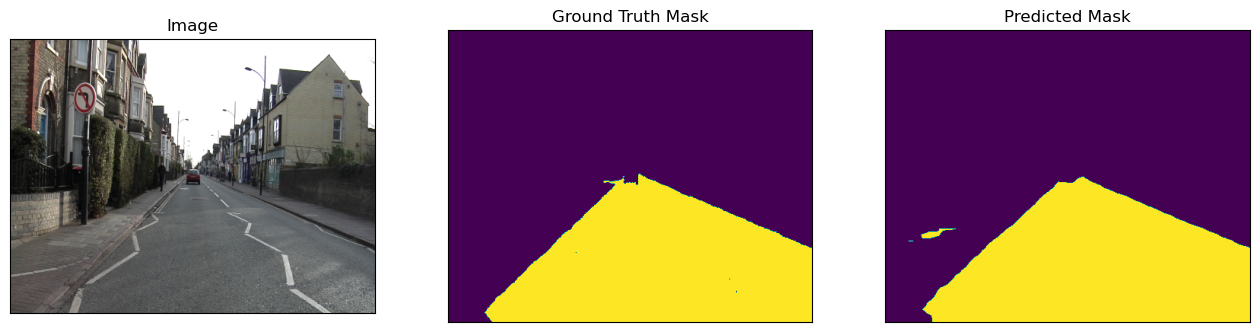

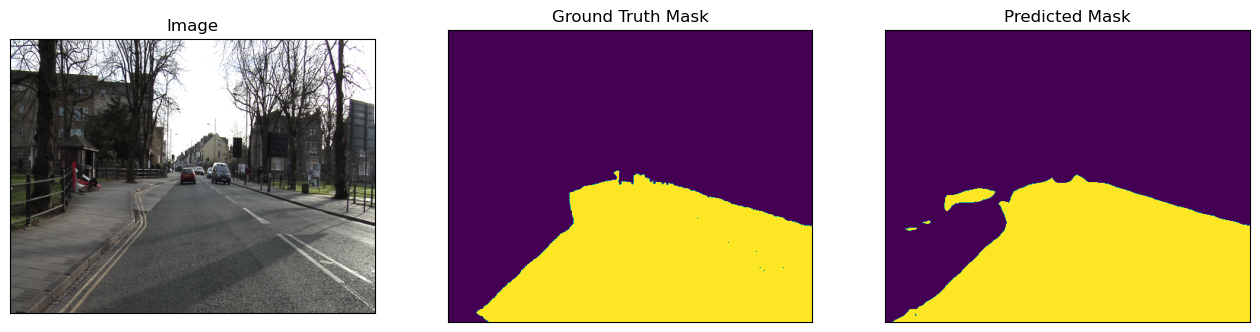

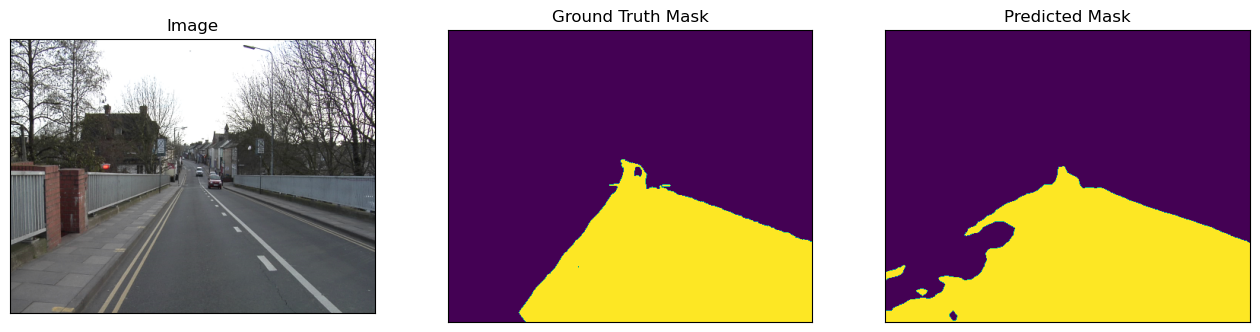

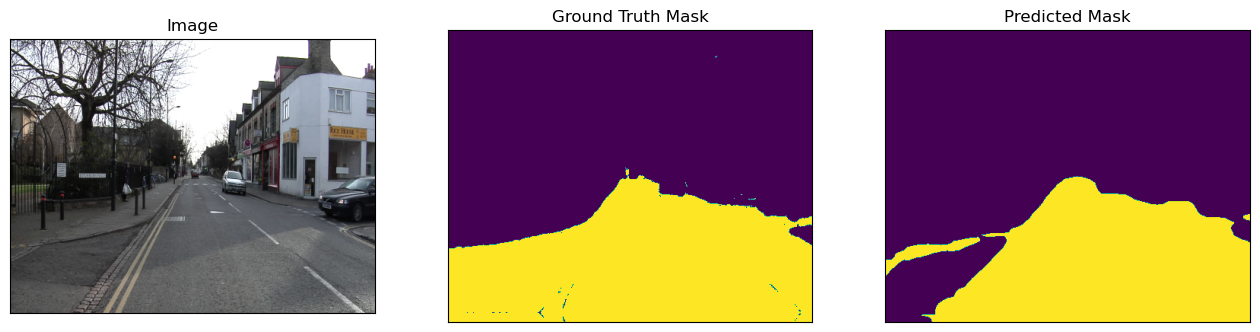

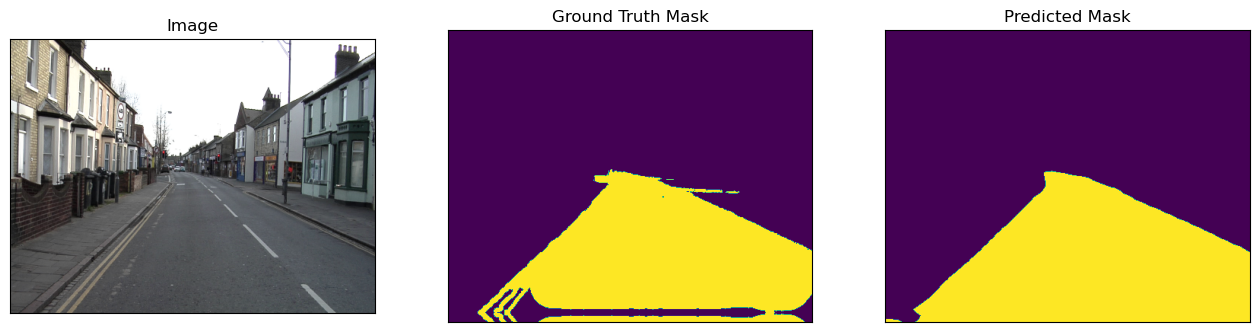

-X-X-X-X-X-X-X-X-X-X




In [34]:
del model

iou_score=[]

# Fix 5 images for visualization
n = [np.random.choice(len(test_dataset)) for i in range(5)]

for model in models:
    torch.cuda.empty_cache()
    best_model = torch.load('./best_model_'+model.name+'.pth')

    test_dataloader = DataLoader(test_dataset)

    # evaluate model on test set
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    print("-"*5+model.name+"-"*5)

    logs = test_epoch.run(test_dataloader)

    iou_score.append(logs['iou_score'].item())

    for i in range(5):

        image_vis = test_dataset_vis[n[i]][0].astype('uint8')
        image, gt_mask = test_dataset[n[i]]
        
        
        gt_mask = gt_mask.squeeze()
        """visualize(image=image[n][0],ground_truth_mask=gt_mask)"""
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
            
        visualize(
            image=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask=pr_mask
        )
    print("-X"*10+"\n\n")


In general, most of our model seemed to be having these issues - 
- Footpath is detected as driveable road or a section near the footpath is deemed un-driveable - This can be very risky.
    - We need to improve our models - either with more data, or with input integration from other sensors like LIDARs (something like height-based filtering), as is practised currently at Abhiyaan.
- Yellow road lines cause unexpected noise - should mostly be avoided with enough relevant data


In a multi-class case, models like Attention UNets could probably be used to give more weight to significant areas, i.e. the road , since we can't afford to have any misclassifications of the driveable area

## Comparing test results

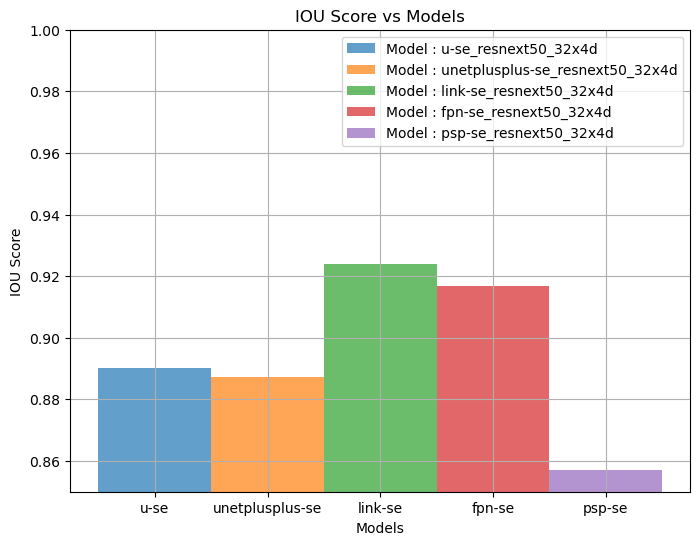

In [72]:
plt.figure(figsize=(8, 6))
# For better scaling
plt.ylim(0.85, 1)

bar_width = 1 # Adjust the width of the bars
for i in range(5):
    plt.bar(models[i].name.split('_')[0], iou_score[i], label=f'Model : {models[i].name}', alpha=0.7, width=bar_width)

# Adding labels and title
plt.grid(True)
plt.xlabel('Models')
plt.ylabel('IOU Score')
plt.title('IOU Score vs Models')
plt.legend()
plt.show()


- As we can see, all our models performed well on the test set (IoU>0.85).

- LinkNet and FPN performed better relatively.

- PSPNet performed the worst. A possible cause for this could be that it is a complicated architecture with a pyramid pooling module in contrast to the UNet-like architecture of most models. It focuses on capturing complex structures in the image data. As is evident from the training loss analysis above, it most likely didn't reach optimality with the limited number of epochs we trained it for, or needs more data for convergence.

# Post-Comments/Ideas

One concern is that our dataset is very 'naive' - there are no instances of obstacles interrupting the car. Also, it isn't relevant to Indian roads - we encounter a far wider range of objects. The bad road condition would significantly affect our models - our models were already struggling when it encountered footpaths. We also need a depth measurement system to avoid potholes and stuff.


I couldn't follow through with a few ideas due to constraints on time/computation. Have mentioned a few here:

### Possible new features or things to add/try :
- Testing the model on different datasets
    - I was planning to use Indian Driving Dataset, however I got stuck in importing it properly, so ditched it
- Multi-class segmentation
    - Final activation layer can be Softmax instead of Sigmoid
    - Binary one-hot encoded seg-masks given by CamVid can be merged into one image - basically reversing the OneHotEncoding
- Import time module to measure training time required for each model (may be a very significant factor in real-time video segmentation)
- Trying different encoders
    - VGG16 and ResNet can be tried, although I didn't try it since ResNext apparently inherits from both anyways.
- Better data augmentation to improve robustness in different weather conditions
    - Albumentations library has interesting augmentations like add_fog, add_gravel, add_rain, add_snow, add_shadow, add_sun_flare - relevant augmentations can be implemented using albu.OneOf